In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go 
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors 
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.metrics import silhouette_samples,calinski_harabasz_score,davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate 
from collections import Counter

%matplotlib inline


In [ ]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [4]:
# Configure Seaborn plot styles: Set background color and use dark grid

sns.set(rc={'axes.facecolor':'#fcf0dc'},style="darkgrid")

In [6]:
#load dataset 
df=pd.read_csv("Data/data.csv", encoding="ISO-8859-1")

In [7]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
df.shape

(541909, 8)

Dataset Description:

1.InvoiceNo:	Code representing each unique transaction. If this code starts with letter 'c', it indicates a cancellation.

2.StockCode:	Code uniquely assigned to each distinct product.

3.Description:	Description of each product.

4.Quantity:	The number of units of a product in a transaction.

5.InvoiceDate: The date and time of the transaction.

6.UnitPrice:	The unit price of the product in sterling.

7.customerID:	Identifier uniquely assigned to each customer.

8.Country: The country of the customer.

In [9]:
#initial analaysis 

df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Inferences:

The dataset consists of 541,909 entries and 8 columns. Here is a brief overview of each column:

InvoiceNo: This is an object data type column that contains the invoice number for each transaction. Each invoice number can represent multiple items purchased in a single transaction.

StockCode: An object data type column representing the product code for each item.

Description: This column, also an object data type, contains descriptions of the products. It has some missing values, with 540,455 non-null entries out of 541,909.

Quantity: This is an integer column indicating the quantity of products purchased in each transaction.

InvoiceDate: A datetime column that records the date and time of each transaction.

UnitPrice: A float column representing the unit price of each product.

CustomerID: A float column that contains the customer ID for each 

transaction. This column has a significant number of missing values, with only 406,829 non-null entries out of 541,909.

Country: An object column recording the country where each transaction took place.

From a preliminary overview, it seems that there are missing values in the Description and CustomerID columns which need to be addressed. The InvoiceDate column is already in datetime format, which will facilitate further time series analysis. We also observe that a single customer can have multiple transactions as inferred from the repeated CustomerID in the initial rows.

The next steps would include deeper data cleaning and preprocessing to handle missing values, potentially erroneous data, and to create new features that can help in achieving the project goals.

In [ ]:
#summary statistics for numerical value 

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [13]:
#summary statistics for categorical variables 

df.describe(include="object").T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


Inferences:

Quantity:

The average quantity of products in a transaction is approximately 9.55.

The quantity has a wide range, with a minimum value of -80995 and a maximum value of 80995. The negative values indicate returned or cancelled orders, which need to be handled appropriately.

The standard deviation is quite large, indicating a significant spread in the data. The presence of outliers is indicated by a large difference between the maximum and the 75th percentile values.

UnitPrice:

The average unit price of the products is approximately 4.61.

The unit price also shows a wide range, from -11062.06 to 38970, which suggests the presence of errors or noise in the data, as negative prices don't make sense.

Similar to the Quantity column, the presence of outliers is indicated by a large difference between the maximum and the 75th percentile values.

CustomerID:

There are 406829 non-null entries, indicating missing values in the dataset which need to be addressed.

The Customer IDs range from 12346 to 18287, helping in identifying unique customers.

InvoiceNo:

There are 25900 unique invoice numbers, indicating 25900 separate transactions.

The most frequent invoice number is 573585, appearing 1114 times, possibly representing a large transaction or an order with multiple items.

StockCode:

There are 4070 unique stock codes representing different products.

The most frequent stock code is 85123A, appearing 2313 times in the dataset.

Description:

There are 4223 unique product descriptions.

The most frequent product description is "WHITE HANGING HEART T-LIGHT HOLDER", appearing 2369 times.

There are some missing values in this column which need to be treated.

Country:

The transactions come from 38 different countries, with a dominant majority of the transactions (approximately 91.4%) originating from the United Kingdom.

**Data Cleaning & Transformation**

In [39]:
#calculete the percentage of missing value foe each column 

missing_data=df.isnull().sum()

missing_percentage= (missing_data[missing_data>0]/df.shape[0])*100

missing_percentage.sort_values(ascending=True, inplace=True)

missing_percentage

Description     0.268311
CustomerID     24.926694
dtype: float64

In [40]:
missing_percentage.index

Index(['Description', 'CustomerID'], dtype='object')

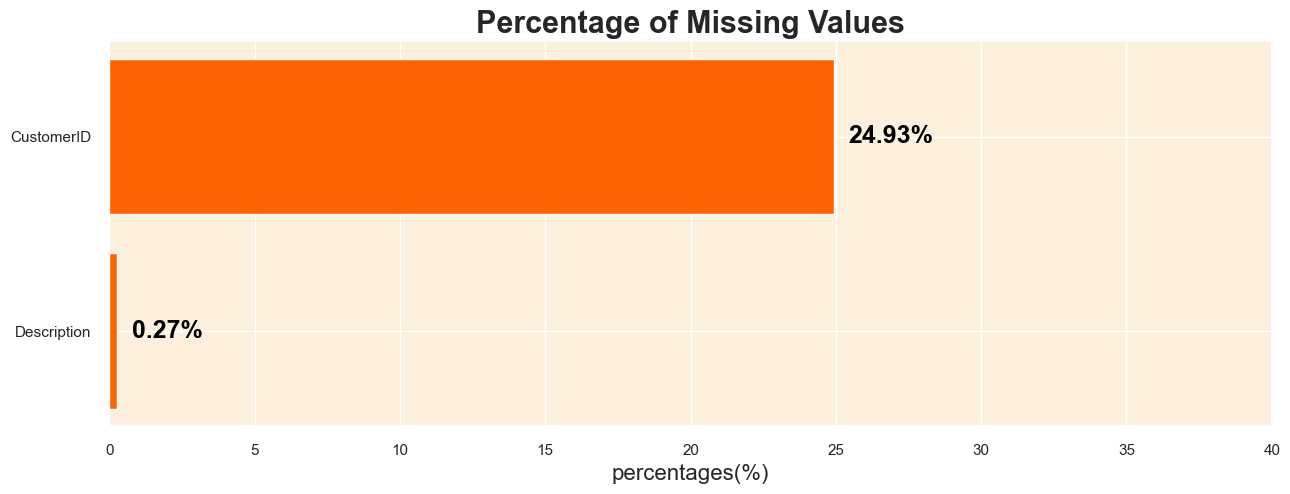

In [41]:
#Plot the barh chart 

fig,ax=plt.subplots(figsize=(15,5))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

for i, (value, name)in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha="left", va="center",fontweight='bold',
    fontsize=18, color='black')

ax.set_xlim([0,40])

plt.title("Percentage of Missing Values", fontweight="bold",fontsize=22)
plt.xlabel('percentages(%)',fontsize=16)
plt.show()

Handling Missing Values Strategy:

CustomerID (24.93% missing values)

The CustomerID column contains nearly a quarter of missing data. This column is essential for clustering customers and creating a recommendation system. Imputing such a large percentage of missing values might introduce significant bias or noise into the analysis.

Moreover, since the clustering is based on customer behavior and preferences, it's crucial to have accurate data on customer identifiers. Therefore, removing the rows with missing CustomerIDs seems to be the most reasonable approach to maintain the integrity of the clusters and the analysis.

Description (0.27% missing values)

The Description column has a minor percentage of missing values. However, it has been noticed that there are inconsistencies in the data where the same StockCode does not always have the same Description. This indicates data quality issues and potential errors in the product descriptions.

Given these inconsistencies, imputing the missing descriptions based on StockCode might not be reliable. Moreover, since the missing percentage is quite low, it would be prudent to remove the rows with missing Descriptions to avoid propagating errors and inconsistencies into the subsequent analyses.

By removing rows with missing values in the CustomerID and Description columns, we aim to construct a cleaner and more reliable dataset, which is essential for achieving accurate clustering and creating an effective recommendation system.

In [ ]:
# Extracting rows with missing values in 'CustomerID' or 'Description' columns
df[df["CustomerID"].isnull()| df["Description"].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [44]:
# Removing rows with missing values in 'CustomerID' and 'Description' columns
df=df.dropna(subset=['CustomerID',"Description"])

In [47]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [54]:
# Handling Duplicate values

duplicate_rows=df[df.duplicated(keep=False)]
duplicate_rows_sorted=duplicate_rows.sort_values(by=["InvoiceNo","StockCode","Description","CustomerID","Quantity"])

duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom


Handling Duplicates Strategy:
In the context of this project, the presence of completely identical rows, including identical transaction times, suggests that these might be data recording errors rather than genuine repeated transactions. Keeping these duplicate rows can introduce noise and potential inaccuracies in the clustering and recommendation system.

Therefore, I am going to remove these completely identical duplicate rows from the dataset. Removing these rows will help in achieving a cleaner dataset, which in turn would aid in building more accurate customer clusters based on their unique purchasing behaviors. Moreover, it would help in creating a more precise recommendation system by correctly identifying the products with the most purchases.

In [55]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

# Removing duplicate rows
df.drop_duplicates(inplace=True)

The dataset contains 5225 duplicate rows that need to be removed.


In [56]:
df.shape

(401604, 8)

In [61]:
#Treating Cancelled Transactions

df[df["InvoiceNo"].astype(str).str.startswith("C")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [ ]:
df["Transaction_status"]=np.where(df["InvoiceNo"].astype(str).str.startswith('C'),'Cancelled',"Completed")



#cancelled_tranasctions.describe().drop("CustomerID",axis=1)

In [67]:
cancelled_transaction=df[df["Transaction_status"]=="Cancelled"]

cancelled_transaction.describe().drop("CustomerID",axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


Inferences from the Cancelled Transactions Data:

All quantities in the cancelled transactions are negative, indicating that these are indeed orders that were cancelled.

The UnitPrice column has a considerable spread, showing that a variety of products, from low to high value, were part of the cancelled transactions.


Strategy for Handling Cancelled Transactions:

Considering the project's objective to cluster customers based on their purchasing behavior and preferences and to eventually create a recommendation system, it's imperative to understand the cancellation patterns of customers. Therefore, the strategy is to retain these cancelled transactions in the dataset, marking them distinctly to facilitate further analysis. This approach will:

Enhance the clustering process by incorporating patterns and trends observed in cancellation data, which might represent certain customer behaviors or preferences.

Allow the recommendation system to possibly prevent suggesting products that have a high likelihood of being cancelled, thereby improving the quality of recommendations.


In [69]:
cancelled_percentage=(cancelled_transaction.shape[0]/df.shape[0])*100

print(f"The percentage of cancelled transaction in the dataset is :{cancelled_percentage: .2f}%")

The percentage of cancelled transaction in the dataset is : 2.21%
